In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.integrate
import scipy.linalg
import math

In [2]:
df = pd.read_csv("../sampledata/shuttle.csv")
data = df["0"]

In [39]:
x_min = np.min(data)
x_max = np.max(data)
data = (data - x_min)
data = data / np.max(data)
data = (data-.5)*2

k=11
p_gen = np.polynomial.chebyshev.Chebyshev
# p_gen = np.polynomial.polynomial.Polynomial
# Polynomial Basis
p_basis = [p_gen.basis(deg=i)for i in range(2*k)]
# Dataset Moments
d_mus = np.array([
    np.mean(p(data)) for p in p_basis
])
# print(repr(d_mus))

In [14]:
def calc_mus(f, mu_k):
    mus = []
    for i in range(mu_k):
        p = p_basis[i]
        v,err = scipy.integrate.quad(
            lambda x: f(x)*p(x), -1, 1,
            epsrel=0.0,
            epsabs=1e-10,
            limit=200
        )
        mus.append(v)
    return np.array(mus)
def gen_pdf(lambd):
    cp = p_gen(lambd)
    def pdf(x):
        return math.exp(-cp(x))
    return pdf

In [15]:
calc_mus(gen_pdf(np.array([1,2,3])),3)

array([ 6.30395464, -1.03958773, -4.9297353 ])

In [29]:
# See newton's method in boyd's convex optimization for importance of step size backtracking
max_steps = 50
def step_backtrack(func, x0, dx, f0, df0):
    alpha = .3
    beta = .25
    t = 1.0
    f1 = func(x0+t*dx)
    while f1 > f0 + alpha*t*np.inner(df0, dx):
        t *= beta
        f1 = func(x0+t*dx)
    return t
def newton2(data_mus):
    k = len(data_mus)
    # Convex potential function P 
    # which has a minimum and gradient 0 when the moments match
    def P(lambd):
        f_pdf = gen_pdf(lambd)
        f_mus = calc_mus(f_pdf, 1)
        return f_mus[0] + np.inner(lambd, data_mus)

    cur_lambd = np.zeros(k)
    steps = 0
    while True:
        pdf = gen_pdf(cur_lambd)
        e_mus = calc_mus(pdf, 2*k)
        f0 = e_mus[0] + np.inner(cur_lambd, data_mus)
        dlambda = data_mus - e_mus[:k]
#         print("dlambda: {}".format(dlambda))
        if np.max(dlambda) < 1e-10:
            return cur_lambd
        # Derivative of chebyshev polynomial
        hh = np.array([[
            (e_mus[i+j] + e_mus[abs(i-j)])*.5
            for i in range(k)
        ] for j in range(k)])
        lambda_step = scipy.linalg.solve(
            hh,
            -dlambda,
            assume_a="pos",
            overwrite_a=True
        )
        t = step_backtrack(P, x0=cur_lambd, dx=lambda_step, f0=f0, df0=dlambda)
        
        cur_lambd += t*lambda_step
        steps += 1
        if steps > max_steps:
            return cur_lambd

In [32]:
lambd_maxent = newton2(mus[:11])

In [57]:
def calc_quantile(f, p, tol=1e-8, fmin=-1, fmax=1):
    def cdf(x):
        y, err = scipy.integrate.quad(f, fmin, x, epsabs=tol, epsrel=tol)
        return y - p
    val = scipy.optimize.brentq(
        f=cdf,
        a=fmin,
        b=fmax,
        xtol=tol,
    )
    return val

In [64]:
p=.5
sdata = np.sort(data)
f_est = gen_pdf(lambd_maxent)
est_q = calc_quantile(f_est, p, tol=1e-5)
est_q_cdf = np.searchsorted(sdata, est_q) / len(sdata)
est_q_error = est_q_cdf - p
q = np.percentile(data, p*100)
print("Estimated p{}: {}".format(p,est_q))
print("True p{}: {}".format(p,q))
print("Quantile Error: {}".format(est_q_error))

Estimated p0.5: -0.6019026023169671
True p0.5: -0.6363636363636364
Quantile Error: 0.04163218390804602


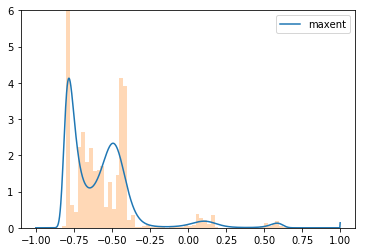

In [38]:
xs = np.linspace(-1,1,1000)
f0 = gen_pdf(lambd_maxent)
y0 = [f0(x) for x in xs]
plt.plot(xs, y0, label="maxent")
_ = plt.hist(data, density=True, bins=80, alpha=.3)
plt.ylim(0,6)
plt.legend()